Data loaded. Shape: (1158, 17)
   survived deck embarked  pclass  embark_town     sex  adult_male    who  \
0         0  NaN        S     3.0  Southampton    male        True    man   
1         1    C        C     1.0    Cherbourg  female       False  woman   
2         1  NaN        S     3.0  Southampton  female       False  woman   
3         1    C        S     NaN  Southampton  female       False  woman   
4         0  NaN        S     3.0  Southampton    male        True    man   

    wspd  lfwa  class      tprc  sibsp   age  alone     fare  parch  
0   22.0  44.0  Third   23.7500    1.0  22.0  False   7.2500    0.0  
1   38.0  76.0  First  215.8499    1.0  38.0  False  71.2833    0.0  
2   26.0  52.0  Third   25.7750    0.0  26.0   True   7.9250    0.0  
3   45.0  70.0  First  161.3000    NaN  35.0  False  53.1000    0.0  
4  235.0  70.0  Third   26.1500    0.0  35.0   True   8.0500    NaN  
After imputation: (1158, 17)
After removing duplicates: (832, 17)
After normalization:

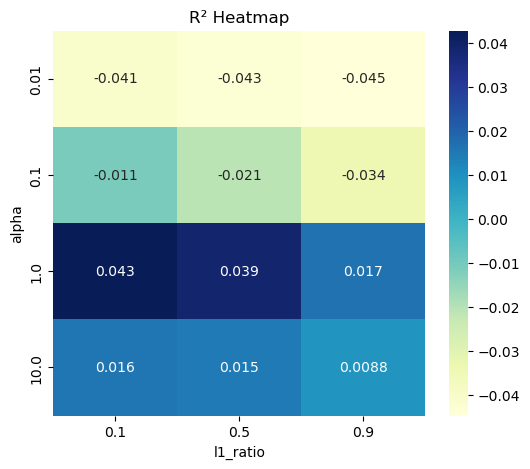

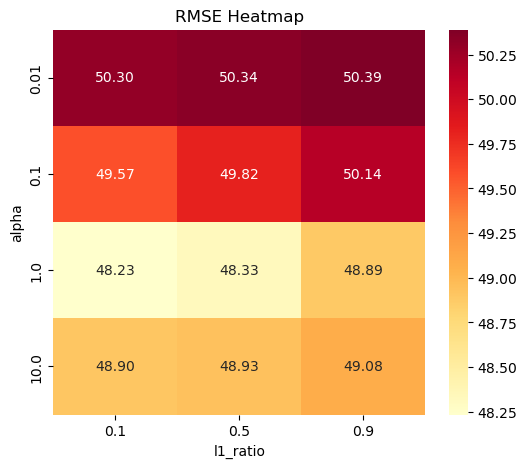

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# 1. Load dataset
messy_data = pd.read_csv('messy_data.csv')
print("Data loaded. Shape:", messy_data.shape)
print(messy_data.head())

# 2. Impute missing values
def impute_missing_values(data, strategy='mean'):
    if strategy == 'mean':
        return data.fillna(data.mean(numeric_only=True))
    elif strategy == 'median':
        return data.fillna(data.median(numeric_only=True))
    elif strategy == 'mode':
        return data.fillna(data.mode().iloc[0])
    else:
        raise ValueError("Invalid strategy. Choose 'mean', 'median', or 'mode'.")

clean_data = impute_missing_values(messy_data, strategy='mean')
print("After imputation:", clean_data.shape)

# 3. Remove duplicates
def remove_duplicates(data):
    return data.drop_duplicates()

clean_data = remove_duplicates(clean_data)
print("After removing duplicates:", clean_data.shape)

# 4. Normalize numerical data
def normalize_data(data, method='minmax'):
    numeric_cols = data.select_dtypes(include='number').columns
    scaler = MinMaxScaler() if method == 'minmax' else StandardScaler()
    data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
    return data

clean_data = normalize_data(clean_data)
print("After normalization:")
print(clean_data.head())

# 5. Remove redundant features
def remove_redundant_features(data, threshold=0.9):
    corr_matrix = data.corr(numeric_only=True).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return data.drop(columns=to_drop)

clean_data = remove_redundant_features(clean_data)
print("After removing redundant features:", clean_data.shape)

# 6. Train and evaluate model
def simple_model(input_data, split_data=True, scale_data=False, print_report=True):
    input_data = input_data.dropna()

    # Assume the first column is the target
    target = input_data.iloc[:, 0]
    features = input_data.iloc[:, 1:]

    # Encode categorical variables
    for col in features.columns:
        if features[col].dtype == 'object':
            dummies = pd.get_dummies(features[col], prefix=col)
            features = pd.concat([features.drop(columns=[col]), dummies], axis=1)

    if split_data:
        X_train, X_test, y_train, y_test = train_test_split(
            features, target, test_size=0.2, stratify=target, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = features, features, target, target

    if scale_data:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)

    if print_report:
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

# Run the model
print("Training model...")
simple_model(clean_data)






#Next Code 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("heart_disease_uci(1).csv")
df = df.dropna()
X = df.drop(columns=['chol', 'num'])  # Drop target and classification label
y = df['chol']

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid search over alpha and l1_ratio
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]
results = []

for alpha in alphas:
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results.append({'alpha': alpha, 'l1_ratio': l1, 'R2': r2, 'RMSE': rmse})

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results)

# Heatmap of R²
r2_matrix = results_df.pivot(index="alpha", columns="l1_ratio", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(r2_matrix, annot=True, cmap="YlGnBu")
plt.title("R² Heatmap")
plt.show()

# Heatmap of RMSE
rmse_matrix = results_df.pivot(index="alpha", columns="l1_ratio", values="RMSE")
plt.figure(figsize=(6, 5))
sns.heatmap(rmse_matrix, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("RMSE Heatmap")
plt.show()

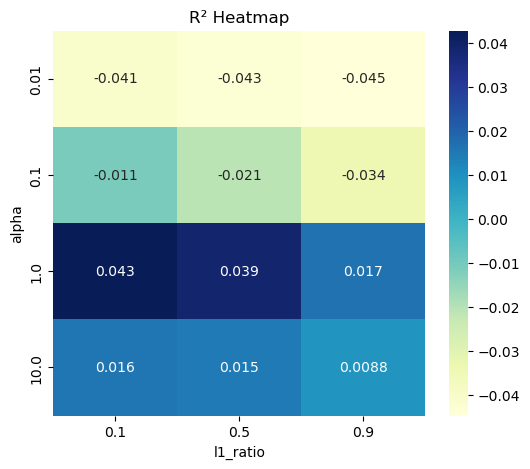

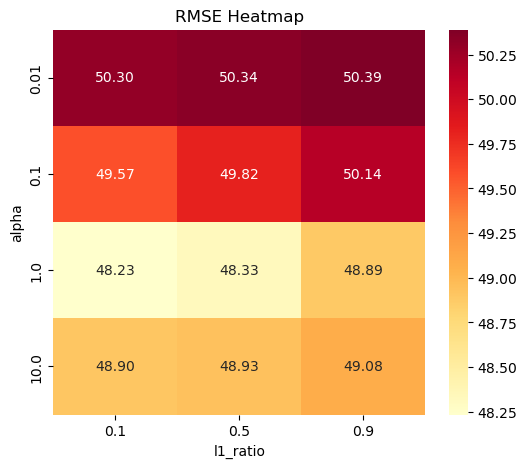

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("heart_disease_uci(1).csv")
df = df.dropna()
X = df.drop(columns=['chol', 'num'])  # Drop target and classification label
y = df['chol']

# One-hot encode categorical columns
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid search over alpha and l1_ratio
alphas = [0.01, 0.1, 1.0, 10.0]
l1_ratios = [0.1, 0.5, 0.9]
results = []

for alpha in alphas:
    for l1 in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results.append({'alpha': alpha, 'l1_ratio': l1, 'R2': r2, 'RMSE': rmse})

# Convert to DataFrame for plotting
results_df = pd.DataFrame(results)

# Heatmap of R²
r2_matrix = results_df.pivot(index="alpha", columns="l1_ratio", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(r2_matrix, annot=True, cmap="YlGnBu")
plt.title("R² Heatmap")
plt.show()

# Heatmap of RMSE
rmse_matrix = results_df.pivot(index="alpha", columns="l1_ratio", values="RMSE")
plt.figure(figsize=(6, 5))
sns.heatmap(rmse_matrix, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("RMSE Heatmap")
plt.show()